# Graph Neural Networks



> ## Acknowledgement
> This notebook is inspired by materials from the [CS224W: Machine Learning with Graphs](https://web.stanford.edu/class/cs224w/) course offered at Stanford University.


First, we install all required packages.



In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch-geometric

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.4.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import networkx as nx
from torch_geometric.utils import to_networkx

# Node Classification with Graph Neural Networks

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

G = to_networkx(data, to_undirected=True)
G.name = 'Planetoid/Cora'

Processing...
Done!



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

The graph holds additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.
Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [ ]:
import torch
from torch.nn import Linear, BatchNorm1d
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Let's visualize the node embeddings of our untrained MLP network. For visualization, we make use of TSNE to embed our 7-dimensional node embeddings onto a 2D plane.

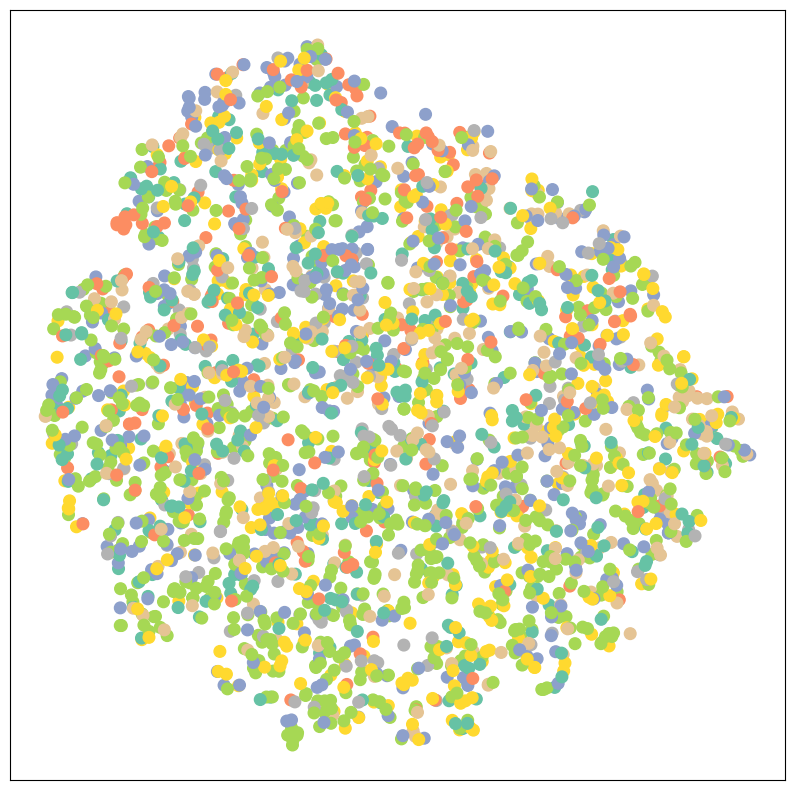

In [ ]:
model.eval()

out = model(data.x)
visualize(out, color=data.y)

Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP. We make use of the **cross entropy loss** and **Adam optimizer**.
We also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
      train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.
      valid_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
      valid_acc = int(valid_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return train_acc, valid_acc, test_acc


for epoch in range(1, 201):
    loss = train()
    train_acc, valid_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train acc: {train_acc:.4f}, Validation acc: {valid_acc:.4f}, Test acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9618, Train acc: 0.1429, Validation acc: 0.1140, Test acc: 0.1030
Epoch: 002, Loss: 1.9590, Train acc: 0.1429, Validation acc: 0.1140, Test acc: 0.1030
Epoch: 003, Loss: 1.9579, Train acc: 0.1429, Validation acc: 0.1140, Test acc: 0.1030
Epoch: 004, Loss: 1.9554, Train acc: 0.1429, Validation acc: 0.1140, Test acc: 0.1030
Epoch: 005, Loss: 1.9536, Train acc: 0.1714, Validation acc: 0.1120, Test acc: 0.1030
Epoch: 006, Loss: 1.9487, Train acc: 0.2357, Validation acc: 0.1160, Test acc: 0.1150
Epoch: 007, Loss: 1.9466, Train acc: 0.2857, Validation acc: 0.1320, Test acc: 0.1350
Epoch: 008, Loss: 1.9417, Train acc: 0.2857, Validation acc: 0.1400, Test acc: 0.1530
Epoch: 009, Loss: 1.9417, Train acc: 0.2857, Validation acc: 0.1400, Test acc: 0.1410
Epoch: 010, Loss: 1.9394, Train acc: 0.2857, Validation acc: 0.1220, Test acc: 0.1280
Epoch: 011, Loss: 1.9383, Train acc: 0.2857, Validation acc: 0.1140, Test acc: 0.1210
Epoch: 012, Loss: 1.9316, Train acc: 0.2786, Validatio

After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [ ]:
test()


(1.0, 0.608, 0.584)

As one can see, our MLP performs rather bad with only about 58.4% test accuracy.
But why does the MLP do not perform better?
The main reason for that is that this model suffers from heavy overfitting due to only having access to a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.



## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

We replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
The **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

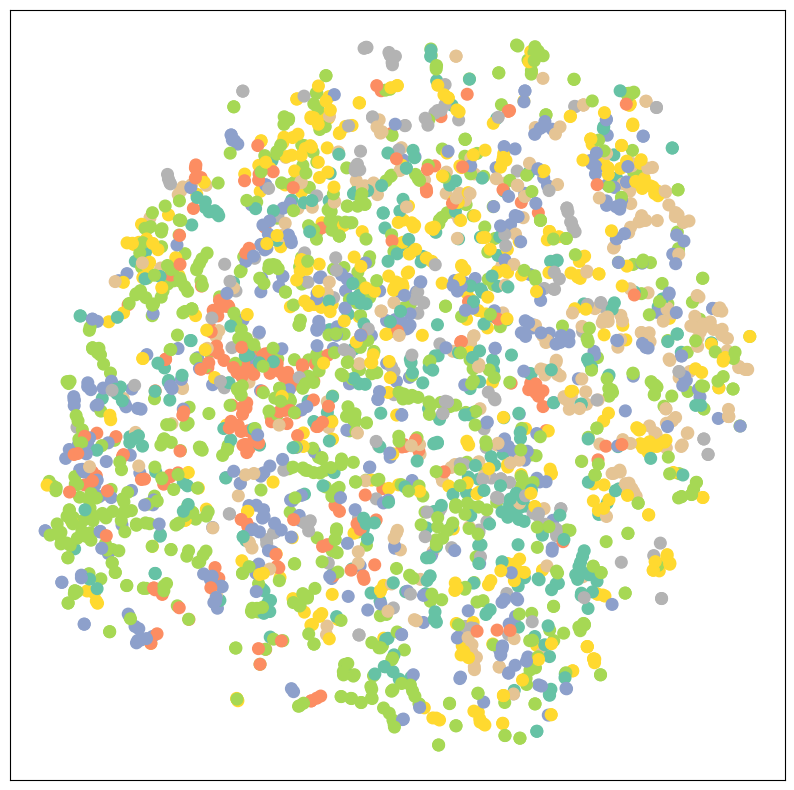

In [ ]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

We certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
      train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.
      valid_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
      valid_acc = int(valid_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return train_acc, valid_acc, test_acc


for epoch in range(1, 201):
    loss = train()
    train_acc, valid_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train acc: {train_acc:.4f}, Validation acc: {valid_acc:.4f}, Test acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
Epoch: 001, Loss: 1.9462, Train acc: 0.3500, Validation acc: 0.2640, Test acc: 0.2470
Epoch: 002, Loss: 1.9390, Train acc: 0.3714, Validation acc: 0.2880, Test acc: 0.3310
Epoch: 003, Loss: 1.9287, Train acc: 0.5643, Validation acc: 0.3100, Test acc: 0.3400
Epoch: 004, Loss: 1.9186, Train acc: 0.6500, Validation acc: 0.4020, Test acc: 0.4390
Epoch: 005, Loss: 1.9032, Train acc: 0.6857, Validation acc: 0.4340, Test acc: 0.4810
Epoch: 006, Loss: 1.8933, Train acc: 0.7571, Validation acc: 0.4980, Test acc: 0.5280
Epoch: 007, Loss: 1.8814, Train acc: 0.8143, Validation acc: 0.5580, Test acc: 0.5950
Epoch: 008, Loss: 1.8682, Train acc: 0.8429, Validation acc: 0.6040, Test acc: 0.6470
Epoch: 009, Loss: 1.8546, Train acc: 0.8571, Validation acc: 0.6280, Test acc: 0.6600
Epoch: 010, Loss: 1.8403, Train acc: 0.8500, Validation acc: 0.6420, Test acc: 0.6630
Epoch: 011, Loss: 1.8271, Train acc: 0.8500, Validation acc: 0.6340, Test acc:

After training the model, we can check its test accuracy:

In [ ]:
train_acc, valid_acc, test_acc = test()
print(f'Train acc: {train_acc:.4f}, Validation acc: {valid_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 0.9929, Validation acc: 0.8040, Test acc: 0.8310


**There it is!**
By simply swapping the linear layers with GNN layers, we can reach **83.1% of test accuracy**!
This is in stark contrast to the 59% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.

We can also verify that once again by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.

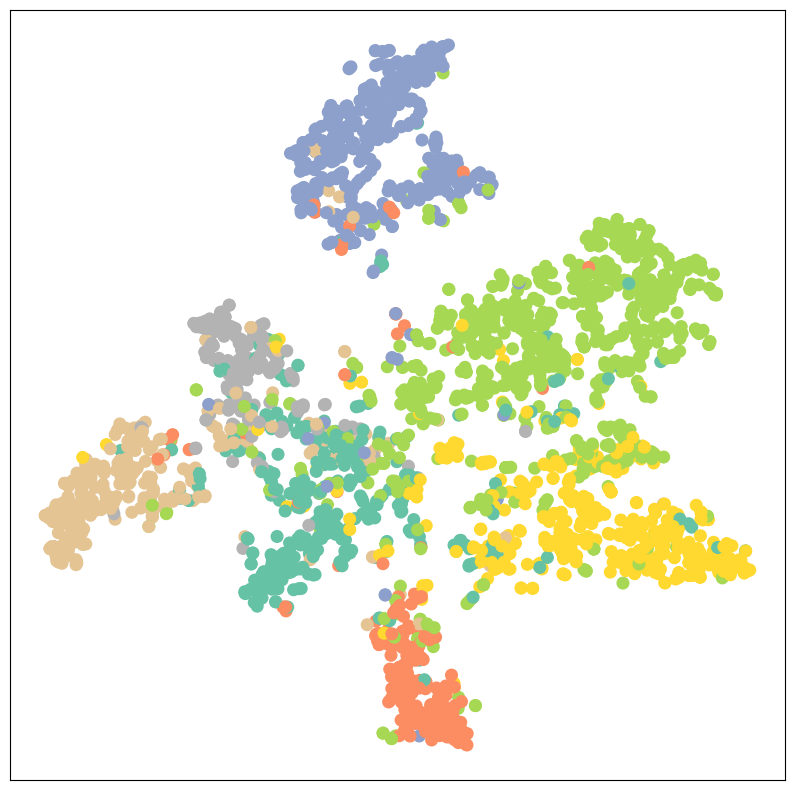

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Conclusion

In this chapter, you have seen how to apply GNNs to real-world problems, and, in particular, how they can effectively be used for boosting a model's performance.
In the next section, we will look into how GNNs can be used for the task of graph classification.

## (Optional) Exercises

1. To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set.
The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet.
Can you modify the code to select and test the model with the highest validation performance?
This should bring test performance to **82% accuracy**.

2. How does `GCN` behave when increasing the hidden feature dimensionality or the number of layers?
Does increasing the number of layers help at all?

3. You can try to use different GNN layers to see how model performance changes. What happens if you swap out all `GCNConv` instances with [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) layers that make use of attention? Try to write a 2-layer `GAT` model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a `dropout` ratio of `0.6` inside and outside each `GATConv` call, and uses a `hidden_channels` dimensions of `8` per head.

In [ ]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels*heads, heads=heads, concat=True)  # TODO
        self.conv2 = GATConv(hidden_channels*heads*heads, dataset.num_classes, heads=1)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 64, heads=8)
  (conv2): GATConv(512, 7, heads=1)
)
Epoch: 001, Loss: 1.9456, Val: 0.6380, Test: 0.6670
Epoch: 002, Loss: 1.9293, Val: 0.7540, Test: 0.7640
Epoch: 003, Loss: 1.9117, Val: 0.7720, Test: 0.7780
Epoch: 004, Loss: 1.8941, Val: 0.7840, Test: 0.7820
Epoch: 005, Loss: 1.8754, Val: 0.7840, Test: 0.7770
Epoch: 006, Loss: 1.8640, Val: 0.7820, Test: 0.7720
Epoch: 007, Loss: 1.8420, Val: 0.7840, Test: 0.7840
Epoch: 008, Loss: 1.8191, Val: 0.7940, Test: 0.7930
Epoch: 009, Loss: 1.8083, Val: 0.7980, Test: 0.8010
Epoch: 010, Loss: 1.7746, Val: 0.8000, Test: 0.8030
Epoch: 011, Loss: 1.7573, Val: 0.7980, Test: 0.8060
Epoch: 012, Loss: 1.7189, Val: 0.7900, Test: 0.8060
Epoch: 013, Loss: 1.6900, Val: 0.7920, Test: 0.8030
Epoch: 014, Loss: 1.6670, Val: 0.7940, Test: 0.8010
Epoch: 015, Loss: 1.6500, Val: 0.7940, Test: 0.8030
Epoch: 016, Loss: 1.6368, Val: 0.7860, Test: 0.8010
Epoch: 017, Loss: 1.5948, Val: 0.7880, Test: 0.8000
Epoch: 018, Loss: 1.5783, Val: 0.78